<a href="https://colab.research.google.com/github/weasel-codes/music-classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATASET CREATION



Extracts MFCCs from music dataset and saves them into a json file along with genre labels.

Different variables used here are :

    :param dataset_path (str): Path to dataset

    :param json_path (str): Path to json file used to save MFCCs

    :param num_mfcc (int): Number of coefficients to extract
    
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples

    :param hop_length (int): Sliding window for FFT. Measured in # of samples

    :param: num_segments (int): Number of segments we want to divide sample tracks into


In [1]:
# LIBRARIES
import json
import os
import math
import librosa

In [ ]:
#CONSTANTS
DATASET_PATH = "/content/drive/MyDrive/ML/songs"
JSON_PATH = "/content/drive/MyDrive/ML/MFCC.json"

SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION # TOTAL samples from a track


In [ ]:
# PROCESS EACH SEGMENT OF AUDIO FILE SEPERATELY
def processEachSegmentOfFile(segment_num, data, file_path, curr_signal, sample_rate, num_mfcc, 
                             n_fft, hop_length, num_mfcc_vectors_per_segment, label_index):
    try :
      mfcc = librosa.feature.mfcc(curr_signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length) # EXTRACT MFCC
      mfcc = mfcc.T
      if len(mfcc) == num_mfcc_vectors_per_segment:     # store only mfcc feature with expected number of vectors
          data["mfcc"].append(mfcc.tolist())
          data["labels"].append(label_index)
 
    except Exception as e:
          print("ERROR : {}, segment:{}".format(file_path, segment_num+1))

In [ ]:
# PROCESS EACH AUDIO FILES SEPARATELY
def processEachAudioFile(data, dirpath, file_name, num_segments, samples_per_segment, 
                         num_mfcc, n_fft, hop_length, num_mfcc_vectors_per_segment, label_index) :

    file_path = os.path.join(dirpath, file_name)  # load audio file from FULL PATH + FILE NAME
    print("Processing file... : ", file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

    for d in range(num_segments):             #process all segments of audio file : DIVIDED one file into MULTIPLE SEGMENTS
        
        start = samples_per_segment * d       #Start time of current segment
        finish = start + samples_per_segment  #Finish Time of segment
        curr_signal = signal[start:finish]    #Extract required samples out of signal

        processEachSegmentOfFile(d, data, file_path, curr_signal, sample_rate, num_mfcc, n_fft, 
                                 hop_length, num_mfcc_vectors_per_segment, label_index)

In [ ]:
# SAVE MFCC-INFO CARRYING DATA-JSON TO A FILE ON DRIVE
def saveDataToJson(data):
    with open(JSON_PATH, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
# Dictionary to store mapping, labels, and MFCCs
data = {
    "mapping": [],  #Relate to labels
    "labels": [],   #Output
    "mfcc": []      #Training Input
}

# PROCESS EACH GENRE
def save_mfcc(num_mfcc, n_fft, hop_length, num_segments):
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # dirpath : folder we are currently in, dirnames : sub-folders or genre, filenames : each file of a genre
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)): # loop through all genre sub-folder

        label_index = i-1
        # ensure we're processing a genre sub-folder level : to make sure we are inside some genre : genre level and not dataset level
        if dirpath is not DATASET_PATH:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label) # No need if we already know what all labels we have
            print("\nProcessing: {}".format(semantic_label))

            for file_name in filenames: # Procesing each file
                processEachAudioFile(data, dirpath, file_name, num_segments, samples_per_segment, 
                                     num_mfcc, n_fft, hop_length, num_mfcc_vectors_per_segment, label_index)

    saveDataToJson(data)

In [ ]:
if __name__ == "__main__":
    num_mfcc=13
    n_fft=2048
    hop_length=512
    num_segments=10
    save_mfcc(num_mfcc, n_fft, hop_length, num_segments)

# Pre-Processing

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [9]:
DATA_PATH = "/content/drive/MyDrive/ML/MFCC.json"

In [10]:
# LOAD JSON DATASET
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y # TARGET AND INPUT

In [11]:
# GENERATE TEST, VALIDATION AND TRAIN SET
def prepare_datasets(test_size, validation_size):
    # load data
    X, Y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis/new_col to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [12]:
# PLOT ACCURACY/LOSS FOR TRAINING/VALIDATION SET USING NO_OF_EPOCHS
def plot_history(history): # Training history of model
    fig, axs = plt.subplots(2)
    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

# CNN MODEL

In [13]:
# param input_shape (tuple): Shape of input set
# return model: CNN model
def build_model(input_shape):
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

# PREDICTION

In [14]:
# PREDICT A SINGLE SAMPLE
def predict(model, X, y):

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

# RUNNER CODE

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)         4

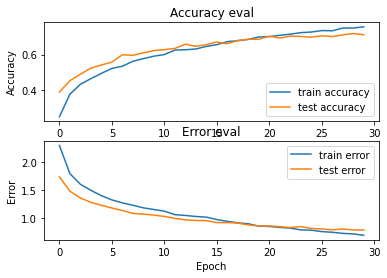

79/79 - 1s - loss: 0.8590 - accuracy: 0.7024

Test accuracy: 0.7024429440498352
Target: 9, Predicted label: [9]


In [15]:
# MAIN RUNNER
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.2, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 1, 32)        

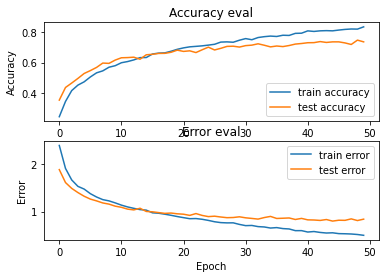


Test accuracy: 0.7107107043266296
Target: 1, Predicted label: [1]


In [16]:
# MAIN RUNNER
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.2, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)